In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import uproot
import os

timestamps = {}

for station in os.listdir('/cr/tempdata01/filip/UubRandoms/Mar2023/converted/timestamps'):
    
    start, stop = np.inf, -np.inf
    for file in np.loadtxt(f"/cr/tempdata01/filip/UubRandoms/Mar2023/converted/timestamps/{station}", usecols=[1, 2]):
        if file[0] < start: start = file[0]
        if file[1] > stop: stop = file[1]
        
    timestamps[station[:-4]] = (start, stop)

#StationIDs = set({'NuriaJr' : 56, 'Peru' : 1737, 'Granada' : 1738, 'Jaco' : 1742, 'LeQuiDon' : 1744, 'RukaMalen' : -1, 'Svenja' : 1733}.values())
Stations = {'NadiaLateFilteredDownsampled' : 1723,
            'NadiaEarlyFilteredDownsampled' : 1723,
            'USA' : 1251, 'Vegetta' : 1732, 'Virginia' : 699, 'Constanza' : 734, 'Lucho' : 972
}

StationIDs, StationNames = list(Stations.values()), list(Stations.keys())

# from my own online algorithm
q_peak = {
    'NadiaEarlyFilteredDownsampled' : np.array([114.9, 124.4, 116.8]),
    'NadiaLateFilteredDownsampled' : np.array([114, 125.3, 113.6]),
    # 'NadiaEarlyT1' : np.array([149.3, 162.6, 152.2]),
    # 'NadiaLateT1' : np.array([148, 161.3, 150.9]),
}

print(StationIDs)
print(StationNames)

[1723, 1723, 1251, 1732, 699, 734, 972]
['NadiaLateFilteredDownsampled', 'NadiaEarlyFilteredDownsampled', 'USA', 'Vegetta', 'Virginia', 'Constanza', 'Lucho']


# Looking at Online Monitoring

In [2]:
t = [[] for _ in range(len(list(Stations.keys())))]
r = [[] for _ in range(len(list(Stations.keys())))]
VEMPeak = [[[], [], []] for _ in range(len(Stations.keys()))]
VEMPeakMeasurement = [[], [], []]
tMeasurement = []


for day in [14, 15, 16, 17, 18, 19, 20]:

    file = uproot.open(f"/cr/tempdata01/filip/UubRandoms/__Monit/mc_2023_03_{day}_00h00.root")

    for j, station in enumerate(StationIDs):
        points = np.argwhere(file["SDMonCal/SDMonCalBranch/fLsId"].array() == station)
        points = [i for l in points for i in l]


        vem = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fPeak[3]"].array()[points]
        rate = file["SDMonCal/SDMonCalBranch/fCalibration/fCalibration.fT1"].array()[points]
        
        for _ in rate: r[j].append(_)

        for i in range(3):
            mask = vem[:,i] != 0
            for x in vem[:,i][mask]:
                VEMPeak[j][i].append(x)
            
                if station == 1251:
                    VEMPeakMeasurement[i].append(x)

        t[j].append(file["SDMonCal/fTime"].array()[points][mask])

        if station == 1251:
            tMeasurement.append(file["SDMonCal/fTime"].array()[points][mask])

tMeasurement = [a for b in tMeasurement for a in b]

for j in range(len(t)):
    t[j] = [i for l in t[j] for i in l]
    # print(f"{len(VEMPeak[j][0])} monits available for {list(StationIDs)[j]}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NadiaLateFilteredDownsampled: [148.9, 162.2, 151.75] NadiaEarlyFilteredDownsampled: [148.9, 162.2, 151.75] USA: [163.8, 40.0, 146.3] 
Vegetta: [160.15, 148.9, 131.8] 
Virginia: [146.85, 200.15, 158.75] 
Constanza: [143.6, 161.75, 47.7] 
Lucho: [139.7, 149.8, 89.45] 


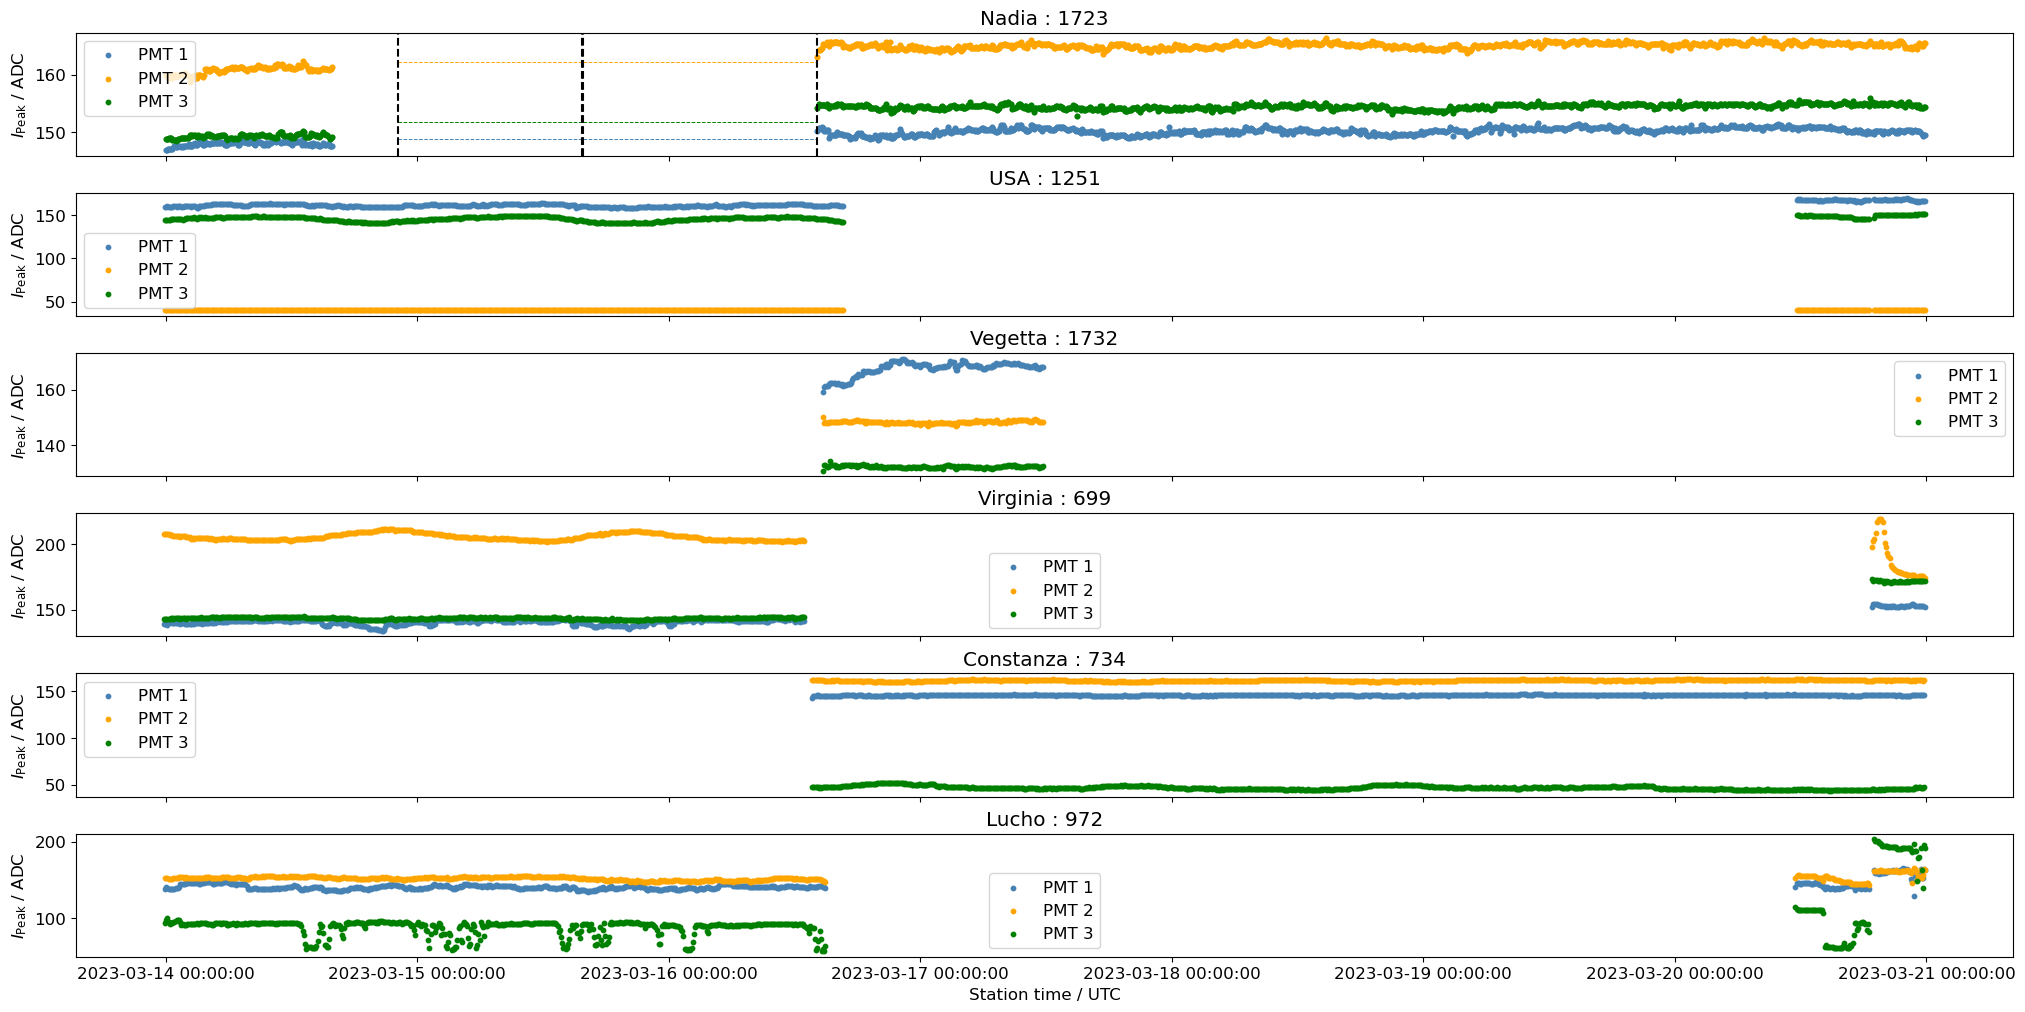

In [10]:
plt.rcParams["figure.figsize"] = [25,12]
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(len(StationIDs)-1, 1, sharex = True)

for i in range(7):
    station = StationNames[i]
    peak = VEMPeak[i]

    if i == 0:
        ax = axes[0]
    elif i == 1:
        ax = axes[0]
        ax.set_title("Nadia : 1723")
    elif i!=0:
        ax = axes[i-1]
        ax.set_title(f"{station} : {Stations[station]}")       


    # find first and last point 
    jump = np.argmax(np.diff(t[i]))
    peak_measurement = [np.round(0.5 * (peak[pmt][jump] + peak[pmt][jump + 1]), 2) for pmt in range(3)]
    print(f'{station}: {peak_measurement}', end=' ')

    try:
        ax.plot(timestamps[station], [peak_measurement[0] for _ in range(2)], ls = '--', lw = 0.7, c = 'steelblue')
        ax.plot(timestamps[station], [peak_measurement[1] for _ in range(2)], ls = '--', lw = 0.7, c = 'orange')
        ax.plot(timestamps[station], [peak_measurement[2] for _ in range(2)], ls = '--', lw = 0.7, c = 'green')

    #     ax.plot(timestamps[station], [q_peak[station][0] for _ in range(2)], c = 'steelblue', lw = 2)
    #     ax.plot(timestamps[station], [q_peak[station][1] for _ in range(2)], c = 'orange', lw = 2)
    #     ax.plot(timestamps[station], [q_peak[station][2] for _ in range(2)], c = 'green', lw = 2)
    #     deviation = [(q_peak[station][i] - peak_measurement[i]) / q_peak[station][i] for i in range(3)]
    #     ax.legend(title = f'deviation = ({deviation[0] * 100:.2f}%, {deviation[1]*100:.2f}%, {deviation[2]*100:.2f}%)')
    #     print(f'{deviation = }')
    except KeyError: print('')

    ax.scatter(t[i], peak[0], s = 10, c = 'steelblue', label="PMT 1" if i!=0 else None)
    ax.scatter(t[i], peak[1], s = 10, c = 'orange', label="PMT 2" if i!=0 else None)
    ax.scatter(t[i], peak[2], s = 10, c = 'green', label="PMT 3" if i!=0 else None)
    ax.legend()
    
    try:
        ax.axvline(timestamps[station][0], c = "k", ls = '--')
        ax.axvline(timestamps[station][1], c = "k", ls = '--')
    except KeyError: pass

    ax.set_ylabel(r"$I_\mathrm{Peak}$ / ADC")

ax.set_xlabel("Station time / UTC")
_ = ax.set_xticks([dt.datetime.timestamp(then) for then in [dt.datetime(2023, 3, d) for d in [14, 15, 16, 17, 18, 19, 20, 21]]], [dt.datetime(2023, 3, d) for d in [14, 15, 16, 17, 18, 19, 20, 21]])

# plt.subplots_adjust(hspace=0.3)
# print(peak_measurement)